In [1]:
from __future__ import print_function

import numpy as np

import numpy as np
import warnings

from keras import backend as K
from keras.utils import np_utils
# from keras.models import *
# from keras.layers import *
from keras.layers.core import *
from keras.layers.pooling import *

from keras.layers.convolutional import *
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.constraints import *
from keras.layers.noise import *

import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, Flatten, BatchNormalization, Reshape, GaussianNoise, UpSampling2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.datasets import mnist

from termcolor import colored 
import random 

from tqdm import tqdm 
import matplotlib.pyplot as plt

from IPython import display
gln = 'glorot_normal'

Using TensorFlow backend.


In [2]:
import os

import warnings 

def supress_warnings():
	warnings.filterwarnings("ignore")


def gpu_conf(gpu_id =0, 
			 load = 0.8):
	os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
	os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

	if K._backend=='tensorflow':
	    print ('Set GPU:')
	    import tensorflow as tf
	    gpu_load = load

	    tf.device('/gpu:' + str(gpu_id))
	    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_load)
	    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
	    #sess=tf.Session()
	    K.set_session(sess)

	    print ("This session will use GPU " + str(gpu_id) + " and  " + str(load) + "of the available GPU")





gpu_conf(gpu_id=0, 
    load = 0.3)

Set GPU:
This session will use GPU 0 and  0.3of the available GPU


In [3]:
# descriminator model definition 

def descriminator(img_dimensions):

	dropout_rate = 0.4 
	# height = img_dimensions[0]
	# width = img_dimensions[1]
	# channels = img_dimensions[2]

	# input_shape = (height, width, channels)

	model_input = Input(shape = img_dimensions.shape)


	#x = Conv2D(filters = 64, kernel_size = 5, strids =, padding = , data_format = , activation=, use_bias=, kernel_initializer =, bias_initialize =)

	x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same')(model_input)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(dropout_rate)(x)

	x = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same')(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(dropout_rate)(x)

	x = Conv2D(filters = 256, kernel_size = 5, strides = 2, padding = 'same')(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(dropout_rate)(x)

	x = Conv2D(filters = 512, kernel_size = 5, strides = 2, padding = 'same')(x)
	x = LeakyReLU(alpha=0.2)(x)
	x = Dropout(dropout_rate)(x)

	x = Flatten()(x)
	x = Dense(2)(x)
	x = Activation('sigmoid')(x)

	model = Model(inputs=model_input, outputs=x)

	return model


# generator model definition 

def generator(g_input):


	dim = 7 
	depth = 64 + 64 + 64 + 64
	input_shape = (100,1)
	dropout_rate = 0.4

	

	# x = GaussianNoise(stddev = 1.0)(g_input)
	x = Dense(7*7*256, input_shape = input_shape, init=gln)(g_input)
	x = BatchNormalization(momentum = 0.9)(x)
	x = Activation('relu')(x)
	x = Reshape((dim, dim, depth))(x)
	x = Dropout(dropout_rate)(x)

	x = UpSampling2D()(x)
	x = Conv2DTranspose(filters=128, kernel_size=5, padding='same')(x)
	x = BatchNormalization(momentum = 0.9)(x)
	x = Activation('relu')(x)

	x = UpSampling2D()(x)
	x = Conv2DTranspose(filters=64, kernel_size=5, padding='same')(x)
	x = BatchNormalization(momentum = 0.9)(x)
	x = Activation('relu')(x)

	x = Conv2DTranspose(filters=32, kernel_size=5, padding='same')(x)
	x = BatchNormalization(momentum = 0.9)(x)
	x = Activation('relu')(x)
	
	x = Conv2DTranspose(filters=1, kernel_size=5, padding='same')(x)
	x = Activation('sigmoid')(x)

	model = Model(inputs = g_input, outputs = x)

	return model

# definition of gan model 

def stacked_gan(desc_model, gen_model):
	# freeze weights for the discriminator model for stacked training 
	make_trainable(desc_model, False)
		
	gan_input = Input(shape=[100])
	H = gen_model(gan_input)
	gan_V = desc_model(H)
	GAN = Model(gan_input, gan_V)

	return GAN

In [4]:
# make model trainable or not tranable 
def make_trainable(net, val):
	net.trainable = val
	for l in net.layers:
		l.trainable = val

In [5]:

# initialize the descriminator model 
img_dim = np.zeros((28,28,1))
desc_model = descriminator(img_dim)
desc_opt = Adam(lr=1e-3)
desc_model.compile(loss = 'categorical_crossentropy', optimizer=desc_opt)
desc_model.summary()


# initialze the generator model 
g_input = Input(shape=[100])
gen_model = generator(g_input)
gen_opt = Adam(lr=1e-4)
gen_model.compile(loss='binary_crossentropy', optimizer=gen_opt)
gen_model.summary()


#initialize the gan model 
gan_model = stacked_gan(desc_model, gen_model)
gan_model.compile(loss='categorical_crossentropy', optimizer = gen_opt)
gan_model.summary()	

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________

/home/sudhakar/dl/local/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12544, kernel_initializer="glorot_normal", input_shape=(100, 1))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
__________

In [6]:
def mnist_data():
	# create mnist dataset 
	img_rows, img_cols = 28, 28
	(X_train, y_train), (X_test, y_test) = mnist.load_data()

	X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
	X_train = X_train.astype('float32')
	X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
	X_test = X_test.astype('float32')

	X_train /= 255. 
	X_test /= 255.

	print (colored('X_train shape: ' + str(X_train.shape[0]), "cyan"))
	print (colored('X_test shape: ' + str(X_test.shape[0]), "cyan"))

	return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = mnist_data()

X_train shape: 60000
X_test shape: 10000


In [7]:

def desc_model_pretrain(desc_model, size_tr_data = 10000):

	# pretrain the discriminator model 
	ntrain = size_tr_data

	trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
	XT = X_train[trainidx, :,:,:]

	# pre_train discriminator network

	noise_gen = np.random.uniform(0,1, size=[XT.shape[0], 100])
	generated_images = gen_model.predict(noise_gen)

	X = np.concatenate((XT, generated_images))
	n = XT.shape[0]
	y = np.zeros([2*n, 2])

	y[:n, 1] = 1
	y[n:, 0] = 1

	make_trainable(desc_model, True)
	desc_model.fit(X, y, epochs= 1, batch_size = 128)

	y_hat = desc_model.predict(X)

	y_hat_idx = np.argmax(y_hat, axis=1)
	y_idx = np.argmax(y, axis=1)
	count = np.sum(y_idx == y_hat_idx)
	accuracy = count * 100 / len(y)

	print (colored("accuracy of the model : %f" %accuracy, "yellow"))

	return desc_model

	

# desc_model = desc_model_pretrain(desc_model)


Epoch 1/1
20000/20000 [==============================] - 7s - loss: 0.0149     
accuracy of the model : 100.000000


In [7]:
#plotting functions - plot the log 
def plot_loss(losses):
	display.clear_output(wait=True)
	display.display(plt.gcf)
	plt.figure(figsize = (10,6))
	plt.plot(losses["d"], label='discriminative loss')
	plt.plot(losses["g"], label ='generative loss')
	plt.legend()
	plt.show()

# plotting function - plot the output 
def plot_gen(gen_model, n_ex = 16, dim= (4,4), figsize= (10,10)):

	noise = np.random.uniform(0,1,size = [n_ex, 100])
	generated_images = gen_model.predict(noise)

	plt.figure(figsize= figsize)
	for i in range(generated_images.shape[0]):
		plt.subplot(dim[0], dim[1], i+1)
		img = generated_images[i,:,:, 0]
		plt.imshow(img)
		plt.axis('off')

	plt.tight_layout()
	plt.show()

<function matplotlib.pyplot.gcf>

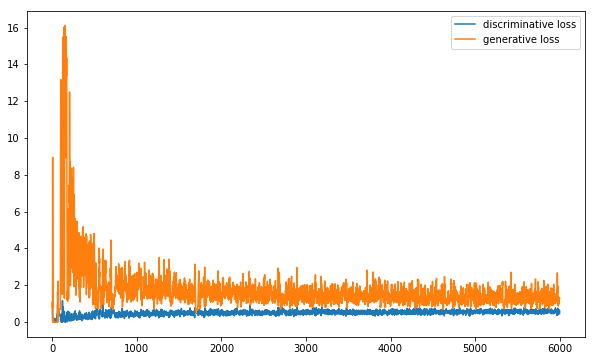

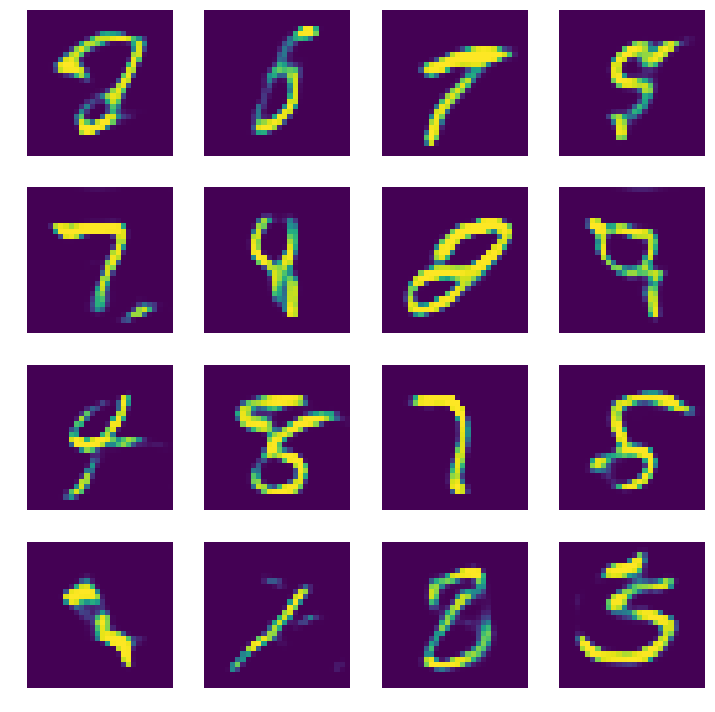

100%|██████████| 6000/6000 [15:12<00:00,  6.57it/s]


In [8]:
from tqdm import tqdm

losses = {"d": [], "g": []}


def train_for_n(gen_model , desc_model, gan_model, epochs = 5000, plt_freq = 25, batch_size = 32):

	# set up mnist dataset 
	X_train, y_train, X_test, y_test = mnist_data()
	
	tr_size = len(X_train)
	te_size = len(X_test)

	for e in tqdm(range(epochs)):

		# make generative images 


		image_batch = X_train[np.random.randint(0,tr_size, size = batch_size)]
		noise_gen = np.random.uniform(0,1,size = [batch_size, 100])
		generated_images = gen_model.predict(noise_gen)

		print ("iteration : %d" %e)


		# train descriminator on generated images 
		X = np.concatenate((image_batch, generated_images))
		y = np.zeros([2*batch_size, 2])

		y[:batch_size, 1] = 1
		y[batch_size:, 0] = 1

		#make trainable True 
		d_loss = desc_model.train_on_batch(X, y)
		losses["d"].append(d_loss)

		print (colored("d_loss : %f"  %d_loss, "yellow"))

		#train generator descriminator stack on input noise to non-generated output classs 

		noise_tr = np.random.uniform(0,1, size=[batch_size, 100])
		y2 = np.zeros([batch_size,2])
		y2[:,1] = 1

		# make trainable (descriminator False)
		g_loss = gan_model.train_on_batch(noise_tr, y2)
		losses["g"].append(g_loss)

		print (colored("generator loss : %f" %g_loss, "cyan"))

		# update plots 

		if(e%plt_freq == plt_freq-1):
			plot_loss(losses)
			plot_gen(gen_model)



train_for_n(gen_model, desc_model, gan_model, epochs=6000, plt_freq=25,batch_size=32)

In [39]:
path = "/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/lfw-deepfunneled/"

import os 

cnt = 0

for root, directories, filenames in os.walk(path):
    for directory in directories:
        print os.path.join(root, directory) 
    for filename in filenames: 
        print (os.path.join(root,filename)) 
        img = cv2.imread(os.path.join(root,filename))
        
        if img is not None:
            img1 = cv2.resize(img, (64,64))
            cv2.imwrite("/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/64x64/" + filename, img1)
            cnt +=1 

    print (cnt)

SyntaxError: invalid syntax (<ipython-input-39-896a931d68cd>, line 9)

In [38]:
import cv2

img = cv2.imread('/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/wiki_crop/99/6040799_1977-04-01_2013.jpg')

print (img.shape)

(114, 114, 3)


In [ ]:
path = "/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/64x64/"

faces = {}
for dirname, folders, filenames in os.walk(path):
    for filename in filenames:
        print filename
        faces[os.path.join("/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/64x64/", filename)] = 0
        
        

In [41]:
import numpy as np 

np.save("./faces.npy", faces)

path = "/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/faces.npy"

faces = np.load(path).item()

X_train = np.zeros((len(faces), 64, 64, 3))

IOError: [Errno 20] Not a directory: '/nas/sudhakar/eyeem/mobile/ssd/org/ssd_eyeem/gan/images/faces/faces.npy/'